In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '../../')

import os
os.chdir('../../')

In [3]:
from src.encode_data import *
from src.midi_data import *
from src.data_sources import process_all
from src.midi_transform import *
from src.fastai_data import *
from src.msklm import *
from src.serve import *

Failed to load FluidSynth. Must install if you want to convert to wav files.


In [4]:
from fastai.text import *

## Example notebook explaining how to encode midi to numpy array and train with fastai

Numpy format 

In [5]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'
midi_path.mkdir(parents=True, exist_ok=True)

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'
numpy_path.mkdir(parents=True, exist_ok=True)

cache_name = 'lm'

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

### 2. Encode midi files to numpy

For more in customized encoding - see `notebooks/dataformatting/2-DataFormatting-AllCombined-X.ipynb`

In [6]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

59628

In [7]:
def process_files(midi_file):
    output_file = Path(str(midi_file).replace(str(data_path), str(numpy_path))).with_suffix('.npy')
    if output_file.exists(): return
    output_file.parent.mkdir(parents=True, exist_ok=True)
    
    # Part 1. Compress tracks/instruments
    npenc = transform_midi(midi_file)
    if npenc is not None: np.save(output_file, npenc)

In [8]:
def transform_midi(midi_file):
    try:
        # 1. Convert file to music21 stream
        stream = file2stream(midi_file) 
        # 2. Convert to uncompressed timestep array
        chordarr = stream2chordarr(stream)
        # 3. Convert to encoded representation
        npenc = chordarr2npenc(chordarr)
        
    except Exception as e:
        print('Could not encode to file:', midi_file, e)
        return None
    
    if not is_valid_npenc(npenc, input_path=midi_file):
        return None
    
    return npenc

In [9]:
processed = process_all(process_files, midi_files[:200], timeout=50, timeout_func=None)

Sequence too short: 19 data/midi/datasets/pianoroll/w/willie-nelson/on-the-road-again/bridge_key_cparallel.mid
Sequence too short: 28 data/midi/datasets/pianoroll/w/willie-nelson/on-the-road-again/verse_key_cmajor.mid
Sequence too short: 15 data/midi/datasets/pianoroll/w/weebl/donkeys/intro_key_cparallel.mid
Sequence too short: 15 data/midi/datasets/pianoroll/w/weebl/donkeys/intro_key_original.mid
Sequence too short: 19 data/midi/datasets/pianoroll/w/willie-nelson/on-the-road-again/bridge_key_cmajor.mid
Sequence too short: 19 data/midi/datasets/pianoroll/w/willie-nelson/on-the-road-again/bridge_key_original.mid
Sequence too short: 24 data/midi/datasets/pianoroll/w/wolfgang-gartner/undertaker/intro_key_cmajor.mid
Sequence too short: 24 data/midi/datasets/pianoroll/w/wolfgang-gartner/undertaker/intro_key_cparallel.mid
Sequence too short: 24 data/midi/datasets/pianoroll/w/wolfgang-gartner/undertaker/intro_key_original.mid
Sequence too short: 28 data/midi/datasets/pianoroll/w/willie-nelson

## 3. Create dataset from encoded files

In [10]:
def create_databunch(files, out_path, cache_name):
    if (out_path/'tmp/train_ids.npy').exists():
        data = MusicDataBunch.load(out_path, cache_name=cache_name)
    else:
        ps = [OpenNPFileProcessor(), SingleEncodeProcessor()]
        data = (MusicItemList(items=files, path=out_path, processor=ps)
                .split_by_rand_pct(0.01, seed=6)
                .label_const(label_cls=LMLabelList))
        data = data.databunch()
        data.save(cache_name)
    return data

In [12]:
numpy_files = get_files(numpy_path, '.npy', recurse=True); len(numpy_files)

182

In [13]:
data = create_databunch(numpy_files, numpy_path, cache_name)

## 4. Load Model

In [14]:
data = MusicDataBunch.load(path=numpy_path, cache_name=cache_name)
data.vocab = vocab

In [15]:
config = tfmerXL_lm_config.copy(); config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 10,
 'd_model': 410,
 'd_head': 41,
 'd_inner': 2100,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.ReLU: 1>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 150,
 'mask': True}

In [16]:
# argspec = inspect.getfullargspec(TransformerXL.__init__)

# argspec

# TransformerXL(**config)

# Using fastai's default config and architecture
# config = v15_config(vocab).copy(); config

# MusicTransformerXL()
# learn = music_model_learner(data, config)

In [17]:
model = get_language_model(TransformerXL, len(vocab.itos), config=config)
learn = MusicLearner(data, model, split_func=tfmerXL_lm_split)

In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,4.239289,3.419954,0.000000,00:03
1,3.675634,3.573203,0.162054,00:02
2,3.431410,3.458749,0.162054,00:02
3,3.177846,3.026716,0.213170,00:02


## 5. Prediction time

In [29]:
midi_files = get_files(data_path, '.mid', recurse=True)
midi_file = midi_files[0]; midi_file

PosixPath('data/midi/datasets/pianoroll/w/wayne-sharpe/yu-gi-oh-theme-song/chorus_key_cmajor.mid')

In [32]:

def midi2npenc(midi_file):
    "Converts midi file to numpy encoding for language model"
    stream = file2stream(midi_file) # 1.
    chordarr = stream2chordarr(stream) # 2.
    npenc = chordarr2npenc(chordarr) # 3.
    return to_single_stream(npenc)

# Decoding process
# 1. NoteEnc -> numpy chord array
# 2. numpy array -> music21.Stream
def npenc2stream(arr, bpm=120):
    "Converts numpy encoding to music21 stream"
    npenc = to_double_stream(arr)
    chordarr = npenc2chordarr(npenc) # 1.
    return chordarr2stream(chordarr, bpm=bpm) # 2.


In [30]:
# # Encode midi file to array for prediction
# stream = file2stream(midi_file) 
# chordarr = stream2chordarr(stream)
# npenc = chordarr2npenc(chordarr)

In [35]:
npenc = midi2npenc(midi_file); npenc.shape

(142,)

Only send a few notes 

In [43]:
# convert numpy encoding to torch tensor. 
seed_len = 100
seed = torch.from_numpy(npenc)[:seed_len][None]; x_inp.shape

torch.Size([1, 100])

Here's what the seed sounds like:

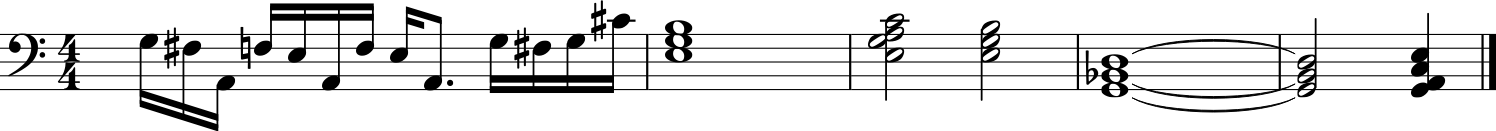

In [45]:
seed_stream = npenc2stream(seed.cpu().numpy()[0])
seed_stream.show()

In [46]:
seed_stream.show('midi')

### Start Predictions:

In [47]:
out, seed = learn.predict(x_inp.cuda(), n_words=100)

Seed - used for prediction

Prediction

In [48]:
# Prediction
stream = npenc2stream(out)
stream.show()

IndexError: index 136 is out of bounds for axis 2 with size 128

In [49]:
stream.show('midi')